In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import os
from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pickle
% matplotlib inline

Aggregate bad words to list

In [48]:
folder = r'Data of bad words'
paths = os.listdir(folder)
list_of_bad_words = []
chars_to_remove = '\n\xa0'
for path in paths:
    curr_path = os.path.join(folder, path)
    with open(curr_path, 'r') as input_file:
        raw_list_of_words = input_file.readlines()
        list_of_bad_words.extend([x.strip(chars_to_remove)
                              for x in raw_list_of_words])
list_of_bad_words = list(set(list_of_bad_words))

Import database of labeld chats

In [49]:
file_path = r'formspring_data.csv.zip'
raw_data = pd.read_csv(file_path, sep='\t')

In [50]:
for ind in range(1,4):
    col = 'severity'+str(ind)
    raw_data[col].loc[raw_data[col] == 'None'] = 0
    raw_data[col].loc[raw_data[col] == 'n/a0'] = 0
    raw_data[col].loc[raw_data[col] == 'n/a'] = 0
    raw_data[col].loc[raw_data[col] == 'o'] = 0
    raw_data[col].loc[raw_data[col] == '0`'] = 0
    raw_data[col].loc[raw_data[col] == '`0'] = 0
    raw_data[col].loc[raw_data[col] == 'N/a'] = 0

Parse database into dataframe

In [51]:
posts, bully_bool, bully_num = [], [], []
for ind, row in raw_data.iterrows():
    post = row['post'].lstrip('Q: ').replace('<br>A: ','')
    posts.append(post)
    severity = [int(row['severity1']), 
                int(row['severity2']), 
                int(row['severity3'])]
    bully_bool.append(severity.count(0) <= 1)
    if bully_bool[ind]:
        bully_num.append(sum(severity) 
                         / (3 - severity.count(0)))
    else:
        bully_num.append(0)

data = pd.DataFrame({'post': posts, 
                     'is_bully': bully_bool,
                     'bully_severity': bully_num})
data.to_csv('parsed_data.csv')

Explore bully comments

In [52]:
word_dict = {}
for ind, row in data.loc[data.loc[:, 'is_bully'] == True, 'post'].iteritems():
    for word in row.split():
        if word.lower() not in word_dict:
            word_dict[word.lower()] = 1
        else:
            word_dict[word.lower()] += 1
sorted(word_dict.items(), key=lambda x: x[1], reverse=True)

[('you', 714),
 ('i', 519),
 ('a', 419),
 ('and', 347),
 ('your', 329),
 ('to', 321),
 ('the', 266),
 ('me', 178),
 ('is', 159),
 ('u', 152),
 ('not', 151),
 ('my', 146),
 ('that', 146),
 ('of', 140),
 ('are', 133),
 ('it', 132),
 ('like', 127),
 ('do', 121),
 ('so', 121),
 ('have', 112),
 ('get', 107),
 ('im', 106),
 ('fake', 105),
 ('on', 103),
 ('know', 98),
 ('r', 98),
 ('who', 93),
 ('be', 93),
 ('dont', 93),
 ('for', 92),
 ('in', 91),
 ('bitch', 85),
 ('fuck', 83),
 ('with', 82),
 ('if', 82),
 ('ur', 81),
 ('just', 79),
 ('no', 79),
 ('what', 78),
 ('shit', 78),
 ('she', 78),
 ('fucking', 73),
 ('her', 70),
 ('how', 69),
 ('one', 69),
 ('think', 68),
 ('would', 67),
 ('but', 66),
 ('stop', 63),
 ('this', 62),
 ('ass', 61),
 ('up', 61),
 ('love', 61),
 ('was', 57),
 ('go', 57),
 ('all', 57),
 ('why', 56),
 ('about', 52),
 ('ugly', 50),
 ('out', 50),
 ('say', 50),
 ('people', 49),
 ('lol', 48),
 ('can', 48),
 ("don't", 45),
 ('off', 45),
 ('as', 43),
 ('at', 43),
 ('life', 42),
 ('

Data to train and test

In [53]:
X = data.loc[:, 'post']
y = data.loc[:, 'is_bully']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3)

In [54]:
def plot_roc_curve(y_true, prob):
    fpr, tpr, th = roc_curve(y_true, prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [55]:
class HeuristicClassifier(object):
    def __init__(self, list_of_words):
        self.list_of_bad_words = list_of_words
        self.prob = []
        self.prob_to_bully = []
    
    def fit(self, X, y):
        sum_words = []
        for ind, row in enumerate(X):
            sentence = row.strip('!').split(' ')
            sum_words.append(sum([word.lower() in self.list_of_bad_words 
                                  for word in sentence]))
            self.prob.append(sum_words[ind] / len(sentence))
        _, _, th = roc_curve(y, self.prob)
        self.thershold = th[-2]
        
    def predict(self, X):
        self.prob_to_bully = []
        if isinstance(X, str) is True:
            X = [X]
        sum_words = []
        for ind, row in enumerate(X):
            sentence = row.strip('!').split(' ')
            sum_words.append(sum([word.lower() in self.list_of_bad_words 
                                  for word in sentence]))
            self.prob_to_bully.append(sum_words[ind] / len(sentence))
            y_pred = [prob > self.thershold for prob in self.prob_to_bully]
        return y_pred
    
    def score(self, X, y):
        y_pred = self.predict(X)
        print('log loss: %s' % log_loss(y, y_pred))
        print('accuracy: %s' % accuracy_score(y, y_pred))

log loss: 5.20975630696
accuracy: 0.849164926931


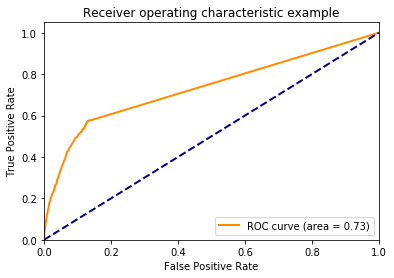

In [56]:
hc = HeuristicClassifier(list_of_bad_words)
hc.fit(X_train, y_train)
hc.score(X_test, y_test)
plot_roc_curve(y_train, hc.prob)

Pickle model

In [57]:
model_file_path = 'model.pickle'
with open(model_file_path, 'wb') as output_file:
    pickle.dump(hc, output_file)

Testing opening pickle

In [58]:
model_file_path = 'model.pickle'
with open(model_file_path, 'rb') as input_file:
    clf = pickle.load(input_file)
    
clf.predict('fuck')

[True]

Dill model

In [59]:
import dill
model_file_path = 'model.pickle'
with open(model_file_path, 'wb') as output_file:
    dill.dump(hc, output_file)

Live demo

In [62]:
file_path = 'C:\ITC\Workshops\Hackaton\watchapp\data\livedemo-conversation-dirty.txt'
with open (file_path, 'r') as input_file:
    for line in input_file:
        curr_line = line.split()[1:]
        curr_line = ' '.join(curr_line)
        print(hc.predict(curr_line), curr_line, hc.prob_to_bully)

[False] Hi, guys! How are you doing? [0.0]
[False] I'm fine, and you? [0.0]
[False] Cool, but Itai is being a big baby! [0.0]
[True] Yeah, he's such a turd! [0.2]
[False] Stop, guys, this is making me sad. [0.0]
[True] Shut up, you wuss! [0.5]
[True] I will beat you after school! [0.16666666666666666]
[False] Stop it guys, that's enough! Not fun anymore. [0.0]


In [63]:
file_path = 'C:\ITC\Workshops\Hackaton\watchapp\data\livedemo-conversation-nice.txt'
with open (file_path, 'r') as input_file:
    for line in input_file:
        curr_line = line.split()[1:]
        curr_line = '_'.join(curr_line)
        print(hc.predict(curr_line), curr_line, hc.prob_to_bully)

[False] Hi,_guys!_How_are_you_doing? [0.0]
[False] I'm_fine,_and_you? [0.0]
[False] Cool,_but_Itai_is_not_here_yet! [0.0]
[False] Yeah,_Itai_is_my_best_friend! [0.0]
[False] Hello!_I_just_got_home. [0.0]
[False] Cool!_We_can_go_to_the_movies_now! [0.0]
[False] We're_going_to_watch_The_Room! [0.0]
[False] It's_going_to_be_totally_rad! [0.0]
